In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle

In [2]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.02
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [3]:
path = '/auto/data2/eTheremin/OSCYPEK/OSCYPEK/OSCYPEK_20240710_SESSION_00/'

In [49]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)

In [37]:
print(len(tt['tones']), len(tt['triggers']))

10185 10184


In [4]:
data = np.load(path+'headstage_0/data_0.02.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.02.npy', allow_pickle=True)
#gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)
gc = np.arange(0, 32)

In [10]:
condition = [elt['Condition'] for elt in features]

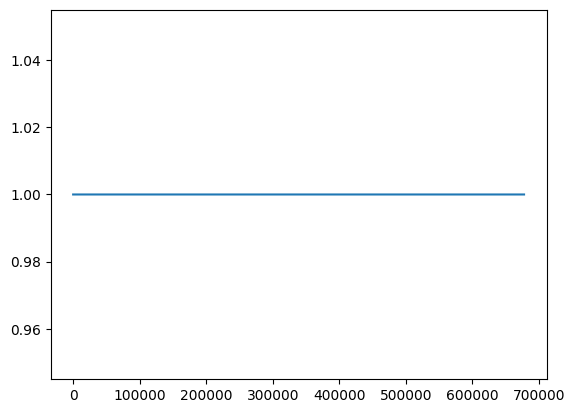

In [11]:
plt.plot(condition)

In [52]:
m = int(len(data[0])/2)
first_features = features[:m]
second_features = features[m:]
first_data = np.vstack([elt[:m] for elt in data])
second_data = np.vstack([elt[m:] for elt in data])

In [66]:
pb_first = get_psth(first_data, first_features, t_pre, t_post, bin_width, gc, 'playback')
pb_second = get_psth(second_data, second_features, t_pre, t_post, bin_width, gc, 'playback')

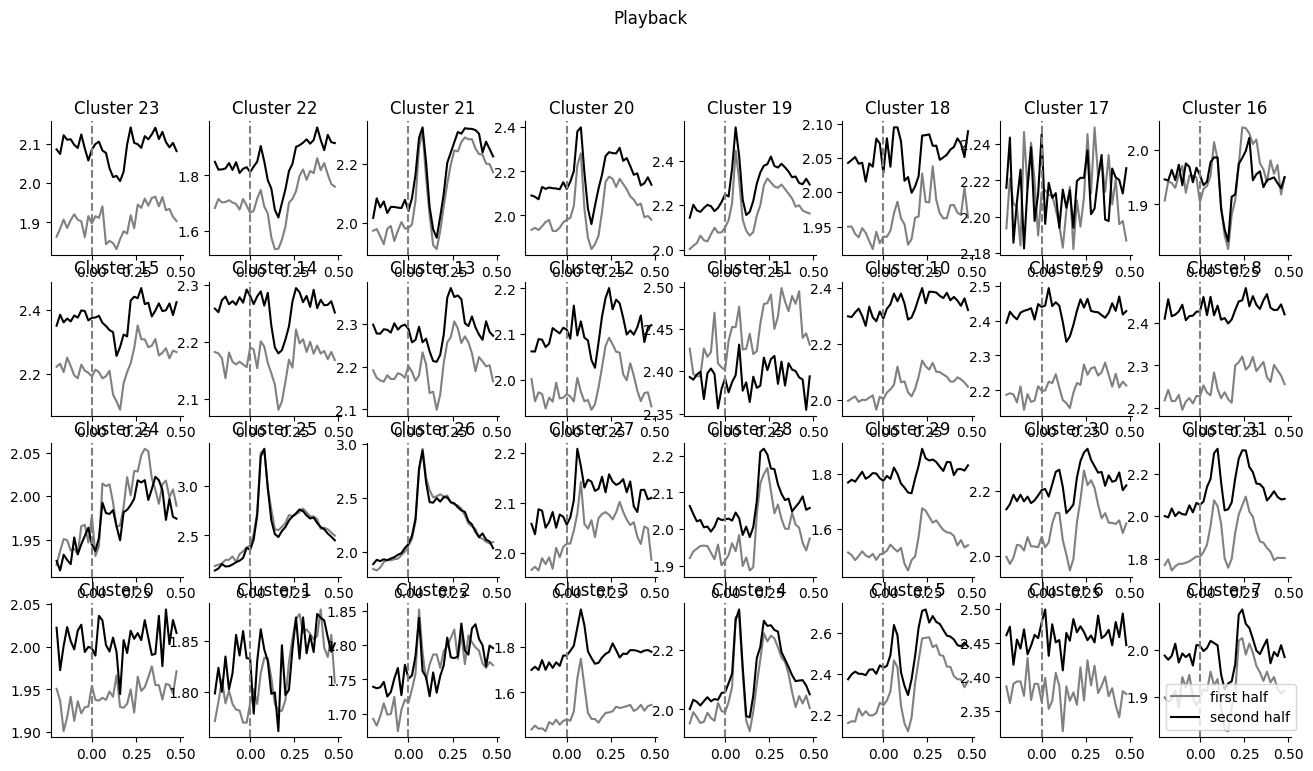

In [67]:
# pour plot cluster par cluster16
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Playback', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(pb_first[cluster], axis=0), c = 'grey', label = 'first half')
        axes[row, col].plot(psth_bins, np.nanmean(pb_second[cluster], axis=0), c = 'black', label = 'second half')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
plt.legend()

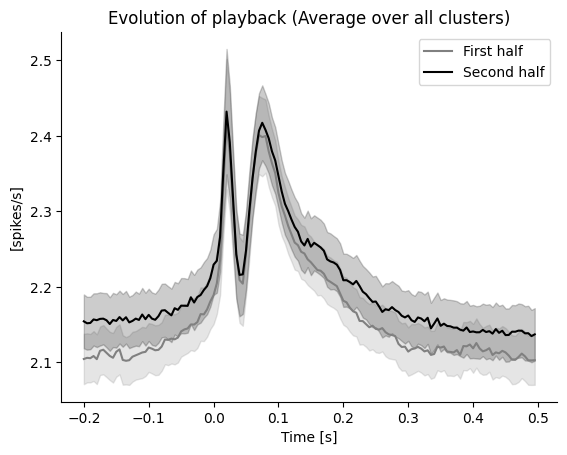

In [27]:


m_first = np.nanmean(pb_first, axis=1)
first = np.nanmean(m_first, axis=0)

m_second = np.nanmean(pb_second, axis=1)
second = np.nanmean(m_second, axis=0)

sem_first_part = get_sem(m_first)
sem_second_part = get_sem(m_second)

# Calculer le test t pour chaque bin
#t_stat, p_value = stats.ttest_rel(m_first, m_second, axis=0)

# Interprétation globale
#alpha = 0.05
#significant_bins = p_value < alpha 
#print(f"Nombre de bins significatifs : {np.sum(significant_bins)}")
#if np.sum(significant_bins)==140:
#    print('significative difference')
#else:
#    print('no significative difference')
    


plt.plot(psth_bins, first, c = 'grey', label = 'First half')
plt.plot(psth_bins, second, c = 'black',  label = 'Second half')
plt.fill_between(psth_bins, first - sem_first_part, first + sem_first_part, color='grey', alpha=0.2)
plt.fill_between(psth_bins, second - sem_second_part, second + sem_second_part, color='black', alpha=0.2)
plt.title('Evolution of playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()


In [5]:

tail = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tail')
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
#mc = get_psth(data, features, t_pre, t_post, bin_width, gc, 'mapping change')
playback = get_psth(data, features, t_pre, t_post, bin_width, gc, 'playback') 

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Créer une colormap allant du rouge foncé au rouge clair
colors = [(0.5, 0, 0), (1, 0.6, 0.6)]  # rouge foncé -> rouge clair
cmap = LinearSegmentedColormap.from_list('red_scale', colors, N=5)

for i in range(1, 6):
    tracking = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'tracking')
    #playback = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'playback')
    c_tracking = np.nanmean(tracking, axis=1)
    #c_playback = np.nanmean(playback, axis=1)
    m_tracking = np.nanmean(c_tracking, axis=0)
    #m_playback = np.nanmean(c_playback, axis=0)
    
    # Appliquer la couleur de l'échelle en fonction du bloc
    plt.plot(m_tracking, label=f'block {i}', color=cmap(i / 5))
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('Evolution of tracking block by block')
plt.show()

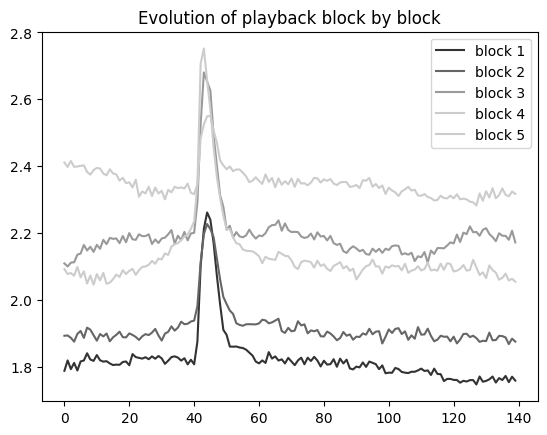

In [15]:
# Créer une colormap allant du noir au gris clair
colors = [(0, 0, 0), (0.8, 0.8, 0.8)]  # noir -> gris clair
cmap = LinearSegmentedColormap.from_list('gray_scale', colors, N=5)

for i in range(1, 6):
    #tracking = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'tracking')
    playback = get_psth_in_block(data, features, t_pre, t_post, bin_width, gc, i, 'playback')
    #c_tracking = np.nanmean(tracking, axis=1)
    c_playback = np.nanmean(playback, axis=1)
    #m_tracking = np.nanmean(c_tracking, axis=0)
    m_playback = np.nanmean(c_playback, axis=0)
    
    # Appliquer la couleur de l'échelle en fonction du bloc
    plt.plot(m_playback, label=f'block {i}', color=cmap(i / 5))

plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Evolution of playback block by block')
plt.show()


In [ ]:
np.save(path+'headstage_0/psth_tracking_0.005.npy', tracking)
np.save(path+'headstage_0/psth_playback_0.005.npy', playback)
#np.save(path+'headstage_0/psth_mappingchange_0.005.npy', mc) 
np.save(path+'headstage_0/psth_tail_0.005.npy', tail)

In [ ]:
tracking = np.load(path+'headstage_0/psth_tracking_0.005.npy', allow_pickle=True)
#mc = np.load(path+'headstage_0/psth_mappingchange_0.005.npy', allow_pickle=True)
tail = np.load(path+'headstage_0/psth_tail_0.005.npy', allow_pickle=True)
playback = np.load(path+'headstage_0/psth_playback_0.005.npy', allow_pickle=True)

In [ ]:
bandwidth = np.load(path+'headstage_0/heatmap_bandwidth.npy', allow_pickle=True)


In [ ]:
get_psth_in_block(data, features, t_pre, t_post, bin_width, good_clusters, block, condition)

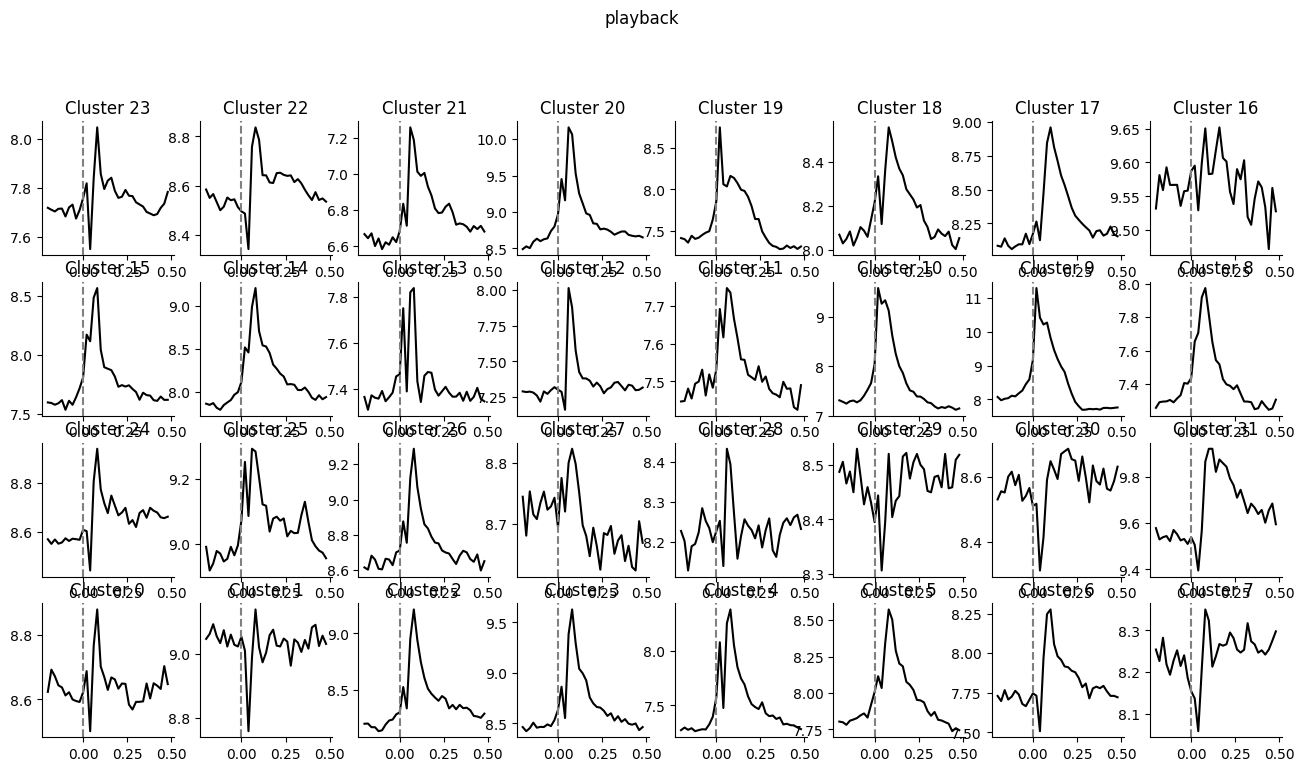

In [7]:
# pour plot cluster par cluster16
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('playback', y=1.02)
plt.subplots_adjust() 
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        #axes[row, col].plot(psth_bins, np.nanmean(tracking[cluster], axis=0), c = 'red')
        axes[row, col].plot(psth_bins, np.nanmean(playback[cluster], axis=0), c = 'black')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

In [ ]:
# faire le meme plot mais block par block pour voir si des le debut ca monte comme ca...

In [ ]:
print('salut')

salut


In [ ]:
c_tracking = np.nanmean(tracking, axis=0)
c_playback = np.nanmean(playback, axis=0)

m_tracking = np.nanmean(c_tracking, axis=0)
m_playback = np.nanmean(c_playback, axis=0)

In [ ]:
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sem_tr = get_sem(c_tracking)
sem_pb = get_sem(c_playback)

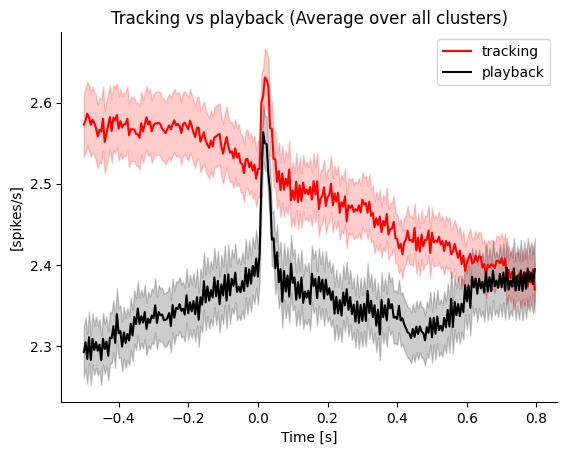

In [ ]:


# Calculer le test t pour chaque bin
#t_stat, p_value = stats.ttest_rel(m_first, m_second, axis=0)

# Interprétation globale
#alpha = 0.05
#significant_bins = p_value < alpha 
#print(f"Nombre de bins significatifs : {np.sum(significant_bins)}")
#if np.sum(significant_bins)==140:
#    print('significative difference')
#else:
#    print('no significative difference')
    


plt.plot(psth_bins, m_tracking, c = 'red', label = 'tracking')
plt.plot(psth_bins, m_playback, c = 'black',  label = 'playback')
plt.fill_between(psth_bins, m_tracking - sem_tr, m_tracking + sem_tr, color='red', alpha=0.2)
plt.fill_between(psth_bins, m_playback - sem_pb, m_playback + sem_pb, color='black', alpha=0.2)
plt.title('Tracking vs playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [ ]:
# je sépare en deux la session (autant de triggers dans la partie 1 que 2)
n = int(len(playback[0])/2)
first_part = [psth[:n] for psth in tracking]
second_part = [psth[n:] for psth in tracking]

# pour plot cluster par cluster
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('tracking divided in 2 parts', y=1.02)
fig.legend()
plt.subplots_adjust() 

for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(first_part[cluster], axis=0), c = 'orange', label = 'First half tracking')
        axes[row, col].plot(psth_bins, np.nanmean(second_part[cluster], axis=0), c = 'red', label = 'Second half tracking')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
fig.legend(['First half tracking', 'Second half tracking'], loc='upper right', bbox_to_anchor=(1, 0.95))


In [ ]:
# je sépare en deux la session (autant de triggers dans la partie 1 que 2)
n = int(len(playback[0])/2)
first_part_playback = [psth[:n] for psth in playback]
second_part_playback = [psth[n:] for psth in playback]

# pour plot cluster par cluster
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('playback divided in 2 parts', y=1.02)
fig.legend()
plt.subplots_adjust() 

for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(first_part_playback[cluster], axis=0), c = 'grey', label = 'First half playback')
        axes[row, col].plot(psth_bins, np.nanmean(second_part_playback[cluster], axis=0), c = 'black', label = 'Second half playback')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
fig.legend(['First half playback', 'Second half playback'], loc='upper right', bbox_to_anchor=(1, 0.95))

In [ ]:
tracking_in, tracking_out = get_mean_psth_in_bandwidth(data, features, bandwidth, t_pre, t_post, bin_width, gc, 'tracking')
playback_in, playback_out = get_mean_psth_in_bandwidth(data, features, bandwidth, t_pre, t_post, bin_width, gc, 'playback')

In [ ]:
def get_psth_in_first_half(data, features, bandwidth, t_pre, t_post, bin_width, good_clusters, condition):
    
    psth_bins = np.arange(-t_pre, t_post + bin_width, bin_width)
    
    if condition=="tracking":
        c = 0
    else : 
        c=1
    in_playback=[]
    for i, cluster in enumerate(good_clusters):
        bd = bandwidth[i]
        if np.isnan(bd).any():
            pass
        else:
            mean_psth_pb = []
            for bin in range(len(data[0])):
                if bin-int(t_pre/bin_width)>0 and bin+int(t_post/bin_width)<len(features):
                    if features[bin]['Frequency_changes']>0 and bd[0]<=features[bin]['Played_frequency']<=bd[1] and features[bin]['Condition']==1:
                        mean_psth_pb.append(data[cluster][bin-int(t_pre/bin_width):bin+int(t_post/bin_width)])
            in_playback.append(np.nanmean(mean_psth_pb, axis=0))
    return in_playback

In [ ]:
first_tr_in = get_psth_in_first_half(first_data, first_features, bandwidth, t_pre, t_post, bin_width, gc, 'tracking')
second_tr_in = get_psth_in_first_half(second_data, second_features, bandwidth, t_pre, t_post, bin_width, gc, 'tracking')

In [ ]:
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('tr clusters', y=1.02)
fig.legend()
plt.subplots_adjust() 

for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, first_tr_in[cluster], c = 'black', label = ' bandwidth')
        axes[row, col].plot(psth_bins, second_tr_in[cluster], c = 'green', label = 'in bandwidth')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
fig.legend(['out', 'in'], loc='upper right', bbox_to_anchor=(1, 0.95))

In [ ]:
first_pb_in = get_psth_in_first_half(first_data, first_features, bandwidth, t_pre, t_post, bin_width, gc, 'playback')
second_pb_in = get_psth_in_first_half(second_data, second_features, bandwidth, t_pre, t_post, bin_width, gc, 'playback')

In [ ]:

num_plots, num_rows, num_columns = get_better_plot_geometry(first_pb_in)
print(num_plots)
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('playback clusters', y=1.02)
fig.legend()
plt.subplots_adjust() 

for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, first_pb_in[cluster], c = 'grey', label = 'in first bandwidth')
        axes[row, col].plot(psth_bins, second_pb_in[cluster], c = 'black', label = 'in second bandwidth')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)
fig.legend(['in first', 'in second'], loc='upper right', bbox_to_anchor=(1, 0.95))

In [ ]:
plt.plot(psth_bins, first, c = 'grey', label = 'First half')
plt.plot(psth_bins, second, c = 'black',  label = 'Second half')
plt.fill_between(psth_bins, first - sem_first_part, first + sem_first_part, color='grey', alpha=0.2)
plt.fill_between(psth_bins, second - sem_second_part, second + sem_second_part, color='black', alpha=0.2)
plt.title('Evolution of playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

In [ ]:
#plot tracking vs playbact_stat, p_value = stats.ttest_rel(avant, apres)k moyenné sur tous les clusters 
first_part = [psth[:n] for psth in playback]
second_part = [psth[n:] for psth in playback]

m_first = np.nanmean(first_part, axis=1)
first = np.nanmean(m_first, axis=0)

m_second = np.nanmean(second_part, axis=1)
second = np.nanmean(m_second, axis=0)

sem_first_part = get_sem(m_first)
sem_second_part = get_sem(m_second)

# Calculer le test t pour chaque bin
#t_stat, p_value = stats.ttest_rel(m_first, m_second, axis=0)

# Interprétation globale
#alpha = 0.05
#significant_bins = p_value < alpha 
#print(f"Nombre de bins significatifs : {np.sum(significant_bins)}")
#if np.sum(significant_bins)==140:
#    print('significative difference')
#else:
#    print('no significative difference')
    


plt.plot(psth_bins, first, c = 'grey', label = 'First half')
plt.plot(psth_bins, second, c = 'black',  label = 'Second half')
plt.fill_between(psth_bins, first - sem_first_part, first + sem_first_part, color='grey', alpha=0.2)
plt.fill_between(psth_bins, second - sem_second_part, second + sem_second_part, color='black', alpha=0.2)
plt.title('Evolution of playback (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()


In [ ]:
#plot tracking vs playbact_stat, p_value = stats.ttest_rel(avant, apres)k moyenné sur tous les clusters 
first_part_tracking = [psth[:n] for psth in tracking]
second_part_tracking = [psth[n:] for psth in tracking]

m_first_tracking = np.nanmean(first_part_tracking, axis=1)
first_tracking = np.nanmean(m_first_tracking, axis=0)

m_second_tracking = np.nanmean(second_part_tracking, axis=1)
second_tracking = np.nanmean(m_second_tracking, axis=0)

sem_first_part_tracking = get_sem(m_first_tracking)
sem_second_part_tracking = get_sem(m_second_tracking)

# Calculer le test t pour chaque bin
#t_stat, p_value = stats.ttest_rel(m_first, m_second, axis=0)

# Interprétation globale
#alpha = 0.05
#significant_bins = p_value < alpha 
#print(f"Nombre de bins significatifs : {np.sum(significant_bins)}")
#if np.sum(significant_bins)==140:
#    print('significative difference')
#else:
#    print('no significative difference')
    


plt.plot(psth_bins, first_tracking, c = 'orange', label = 'First half')
plt.plot(psth_bins, second_tracking, c = 'red',  label = 'Second half')
plt.fill_between(psth_bins, first_tracking - sem_first_part_tracking, first_tracking + sem_first_part_tracking, color='orange', alpha=0.2)
plt.fill_between(psth_bins, second_tracking - sem_second_part_tracking, second_tracking + sem_second_part_tracking, color='red', alpha=0.2)
plt.title('Evolution of tracking (Average over all clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()


In [ ]:
# Comparer les psth en début de session et fin de session ou toutes les 5 min
print('jai tourné')
 

In [ ]:
# comparer le cas où le furet arrive de la droite ou de la gauche
indices_frequency_changes = []

# Parcourir le tableau et vérifier la condition
for i, item in enumerate(features):
    if item['Frequency_changes']:
        indices_frequency_changes.append(i)
        

indices_increase = []
indices_decrease = []

# Parcourir les indices pour diviser en deux groupes
for idx in indices_frequency_changes:
    # Vérifier si l'indice précédent existe
    if idx > 0:
        prev_played_freq = features[idx - 1]['Played_frequency']
        curr_played_freq = features[idx]['Played_frequency']
        
        if prev_played_freq < curr_played_freq:
            indices_increase.append(idx)
        elif prev_played_freq > curr_played_freq:
            indices_decrease.append(idx)


In [ ]:
tr_decrease = get_psth_for_indexes(data, features, indices_decrease, t_pre, t_post, bin_width, gc, 'tracking')
tr_increase = get_psth_for_indexes(data, features, indices_increase, t_pre, t_post, bin_width, gc, 'tracking')
pb_decrease = get_psth_for_indexes(data, features, indices_decrease, t_pre, t_post, bin_width, gc, 'playback')
pb_increase = get_psth_for_indexes(data, features, indices_increase, t_pre, t_post, bin_width, gc, 'playback')